In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import os
import nc_time_axis
import matplotlib.pyplot as plt
#from geocat.viz import util as gvutil
import cartopy
import xesmf as xe
import xskillscore as xs
#cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
%matplotlib inline

from mypyutils import calendar_utils as cal
from mypyutils import stat_utils as stat
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import io_utils as io
from mypyutils import regrid_utils as regrid

In [2]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason_tg(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear_tg(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea  
    return fosi_desea.drop_vars('month'), fosi_trend
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    # fosi_desea=da.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [3]:
import dask
from dask.distributed import wait
dask.__version__

'2023.7.0'

## Create Dask Cluster

In [14]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
client.shutdown()
!rm dask-worker*

In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='30GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=30GB',
        account='UARH0002',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/clittle/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/clittle/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.177:35747,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/clittle/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [21]:
ls /glade/work/yeager/datashare/ALPACA/

g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.B.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.M.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.RYF0304.003.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.B.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.M.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.RYF0304.001.pop.h.000101_006612.SSH.nc


In [9]:
# ylo=1400; yhi=1800; xlo=0; xhi=700; #HR2 EC SMALL
ylo=1200; yhi=2200; xlo=100; xhi=1000; #HR2 EC SMALL

# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.M.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.B.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
ds=ds.chunk(40, 100, 100)
da1=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()
da=da1
# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.RYF0304.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=ds.chunk(40, 100, 100)
# da2=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc')
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.B.001.pop.h.000101_006612.SSH.nc')
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.M.001.pop.h.000101_006612.SSH.nc')
# ds = cal.time_set_midmonth(ds, "time") #LR
# # ds=ds.where(ds.SSH < 1e5)
# ds2 = cal.time_set_midmonth(ds2, "time") #LR
# ds2=ds2.where(ds2.SSH < 1e5)
# da=da1-da2

In [15]:
ylo=1400; yhi=1800; xlo=0; xhi=700; #HR2 EC SMALL

# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.M.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# # ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.B.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=ds.chunk(40, 100, 100)
# ds = cal.time_set_midmonth(ds, "time") #LR
# ds=ds.where(ds.SSH < 1e5)
# da=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()

# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.RYF0304.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=ds.chunk(40, 100, 100)
# da2=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()
ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc')
da=ds.SSH.isel(time=slice(792-31*12,792-12))#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.B.001.pop.h.000101_006612.SSH.nc')
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.M.001.pop.h.000101_006612.SSH.nc')
# ds2 = cal.time_set_midmonth(ds2, "time") #LR
# ds2=ds2.where(ds2.SSH < 1e5)

In [54]:
# da=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# da1=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# da2=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# ylo=1200; yhi=2200; xlo=100; xhi=1000; #HR2 EC SMALL
# xlo=260; xhi=320; ylo=250; yhi=350;
# da=da1-da2
# da=da.isel(time=slice(792-31*12,792-12))#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))

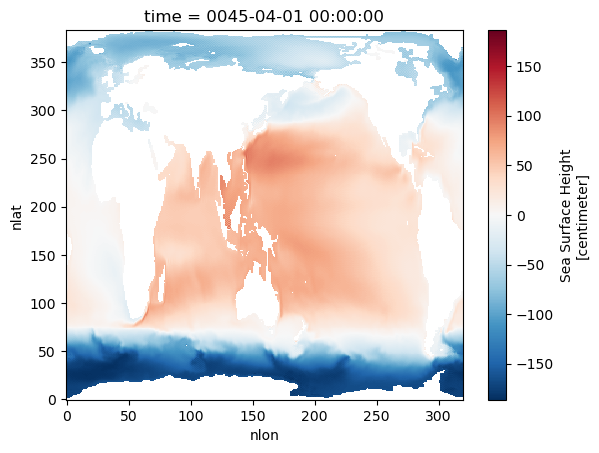

In [17]:
# (da[110,:,:]).plot()

In [10]:
da.load()

<xarray.DataArray 'SSH' (time: 360, nlat: 1000, nlon: 900)>
array([[[ 2.2856358e+01,  2.2841686e+01,  2.2872896e+01, ...,
          8.7866500e-02,  7.4768834e-02,  6.3806601e-02],
        [ 2.3089003e+01,  2.3118828e+01,  2.3101849e+01, ...,
          2.7937555e-01,  2.6490247e-01,  2.5058919e-01],
        [ 2.3361115e+01,  2.3349262e+01,  2.3378712e+01, ...,
          4.7411719e-01,  4.5541763e-01,  4.4046432e-01],
        ...,
        [           nan,            nan,            nan, ...,
         -8.9544815e+01, -9.0035889e+01, -9.0368050e+01],
        [           nan,            nan,            nan, ...,
         -8.9474030e+01, -8.9502281e+01, -8.9578629e+01],
        [           nan,            nan,            nan, ...,
         -9.0100159e+01, -8.9617996e+01, -8.9148575e+01]],

       [[ 2.2450821e+01,  2.2421562e+01,  2.2433754e+01, ...,
         -1.1147653e+00, -1.1312907e+00, -1.1363455e+00],
        [ 2.2665594e+01,  2.2675131e+01,  2.2651276e+01, ...,
         -9.1329449e-01, -9.1945881e-01, -9.3728918e-01],
        [ 2.2923210e+01,  2.2897013e+01,  2.2909739e+01, ...,
         -7.0151275e-01, -7.1981806e-01, -7.2790807e-01],
...
        [           nan,            nan,            nan, ...,
         -8.7460442e+01, -8.7628136e+01, -8.7496094e+01],
        [           nan,            nan,            nan, ...,
         -8.6341423e+01, -8.6106651e+01, -8.5696518e+01],
        [           nan,            nan,            nan, ...,
         -8.5091499e+01, -8.4582672e+01, -8.3846466e+01]],

       [[ 2.4449429e+01,  2.4423595e+01,  2.4434355e+01, ...,
          8.3949971e-01,  8.1752145e-01,  8.2967508e-01],
        [ 2.4720232e+01,  2.4738304e+01,  2.4706974e+01, ...,
          1.0676413e+00,  1.0811678e+00,  1.0595870e+00],
        [ 2.5040098e+01,  2.5007971e+01,  2.5020466e+01, ...,
          1.3268087e+00,  1.3017449e+00,  1.3145802e+00],
        ...,
        [           nan,            nan,            nan, ...,
         -9.0703346e+01, -8.9787148e+01, -8.8645660e+01],
        [           nan,            nan,            nan, ...,
         -8.7968948e+01, -8.6593910e+01, -8.5148499e+01],
        [           nan,            nan,            nan, ...,
         -8.4676926e+01, -8.3099693e+01, -8.1596672e+01]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 1.85 1.85 1.85 1.85 ... 79.29 79.27 79.26
    TLONG    (nlat, nlon) float64 260.1 260.1 260.2 260.3 ... 3.872 4.093 4.314
  * time     (time) object 0036-02-01 00:00:00 ... 0066-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

In [11]:
[hrdesea, hrtrend]=detrend_deseason(da)

In [12]:
import momlevel
import pandas as pd
tgcsvin="./tgs_in_93_22.csv" #need to read in from csv for momlevel
tgs_in=pd.read_pickle("./tgs_in_93_22.pkl")
omask=xr.where(np.isnan(da[0,:,:]), 0, 1)
tgs_hr_xr=momlevel.extract_tidegauge(hrdesea, da.TLONG, da.TLAT, mask=omask, csv=tgcsvin)
tgs_hr_xr=tgs_hr_xr.to_array("tgindex", name="ssh").to_dataset().assign_coords(
    tgindex=tgs_in.name.to_list()
)


In [13]:
# !rm /glade/derecho/scratch/clittle/alpaca_hr_ssh_m-r_tgs.nc
tgs_hr_xr.to_netcdf('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_b_det.nc',mode='w')

In [33]:
# !rm /glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r.nc
# hrdesea
# # hrdesea.to_netcdf('/glade/derecho/scratch/clittle/LRSSH1920_2005_10mem_1deg.nc',mode='w')
hrdesea=hrdesea.to_dataset(name='ssh')
hrdesea.to_netcdf('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc',mode='w')